# Capstone 3 - Automating Deferral Discrepancy Report

# Data Wrangling

In [1]:
#load modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport 
from ipywidgets import widgets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
#importing csv raw data file

df = pd.read_csv('../data/raw/RawData_DV_CapstoneThree.csv')
df.head()

,send,Internal Comments,rundate,Comment,planid,partid,prperiodend,postdate,PayrollFileCompensation,PayrollFileDeferralAmt,...,PayrollFileCalculatedRate,InternalRecordsRate,PR%-internal%,calceffdate,InternalRequestDate,InternalRecordsRequestOrigin,InternalRecordsPctRequest,InternalRecordsDollarRequest,changeschedule,AnnualDeferralLimit
0,no,"no send, Effective date within 1 week of PR da...",1/11/2021,IMPORTANT: Internal records show higher defer...,1,1,1/8/2021,1/8/2021,2080.80,62.42,...,3.00,6.00,-3.00,1/8/2021,1/8/2021,Participant Web,6.0,0.0,U,19500
1,no,"no send, Effective date within 1 week of PR da...",1/11/2021,IMPORTANT: Internal records show higher defer...,2,2,1/8/2021,1/8/2021,2273.08,272.77,...,12.00,13.00,-1.00,1/7/2021,1/7/2021,CSR,13.0,0.0,U,19500
2,no,"no send, Effective date within 1 week of PR da...",1/11/2021,IMPORTANT: Internal records show higher defer...,3,3,1/7/2021,1/7/2021,10416.87,644.00,...,6.18,7.86,-1.68,1/7/2021,1/7/2021,Participant Web,0.0,819.0,U,19500
3,no,"no send, Effective date within 1 week of PR da...",1/11/2021,Internal records show lower deferral rate. Ple...,1,4,1/8/2021,1/8/2021,4615.38,692.31,...,15.00,6.00,9.00,1/7/2021,1/7/2021,Participant Web,6.0,0.0,U,19500
4,no,"no send, Effective date within 1 week of PR da...",1/11/2021,Internal records show lower deferral rate. Ple...,1,5,1/8/2021,1/8/2021,1846.16,129.23,...,7.00,6.00,1.00,1/7/2021,1/7/2021,Participant Web,6.0,0.0,U,19500


In [3]:
#getting a general sense of the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32177 entries, 0 to 32176
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   send                          32177 non-null  object 
 1   Internal Comments             32177 non-null  object 
 2   rundate                       32177 non-null  object 
 3   Comment                       32177 non-null  object 
 4   planid                        32177 non-null  int64  
 5   partid                        32177 non-null  int64  
 6   prperiodend                   32177 non-null  object 
 7   postdate                      32177 non-null  object 
 8   PayrollFileCompensation       32177 non-null  float64
 9   PayrollFileDeferralAmt        32177 non-null  float64
 10  YearToDateDeferrals           32177 non-null  float64
 11  pretaxrothcd                  32177 non-null  object 
 12  PayrollFileCalculatedRate     32177 non-null  float64
 13  I

## Cleaning data

In [4]:
#renaming columns

df = df.rename(columns = {
    'Internal Comments':'internal_scrub_comments', 
    'rundate':'report_date',
    'Comment':'discrepancy_type',
    'planid':'plan_cd',
    'partid':'part_cd',
    'prperiodend':'pr_run_date',
    'postdate':'pr_post_date',
    'PayrollFileCompensation':'pr_comp', 
    'PayrollFileDeferralAmt':'pr_def_amt', 
    'YearToDateDeferrals':'ytd_def_amt',
    'pretaxrothcd':'pretax_roth_cd',
    'PayrollFileCalculatedRate':'pr_def_pct', 
    'InternalRecordsRate':'internal_pct_calc', 
    'PR%-internal%':'diff_pr_internal_pct',
    'calceffdate':'rate_eff_date',
    'InternalRequestDate':'rate_req_date',
    'InternalRecordsRequestOrigin':'rate_req_origin_cd',
    'InternalRecordsPctRequest':'rate_req_if_pct', 
    'InternalRecordsDollarRequest':'rate_req_if_amt',
    'changeschedule':'plan_change_schedule_cd',
    'AnnualDeferralLimit':'annual_irs_limit'
})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32177 entries, 0 to 32176
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   send                     32177 non-null  object 
 1   internal_scrub_comments  32177 non-null  object 
 2   report_date              32177 non-null  object 
 3   discrepancy_type         32177 non-null  object 
 4   plan_cd                  32177 non-null  int64  
 5   part_cd                  32177 non-null  int64  
 6   pr_run_date              32177 non-null  object 
 7   pr_post_date             32177 non-null  object 
 8   pr_comp                  32177 non-null  float64
 9   pr_def_amt               32177 non-null  float64
 10  ytd_def_amt              32177 non-null  float64
 11  pretax_roth_cd           32177 non-null  object 
 12  pr_def_pct               32177 non-null  float64
 13  internal_pct_calc        32177 non-null  float64
 14  diff_pr_internal_pct  

In [5]:
#dealing with missing data

df.isna().sum()

send                          0
internal_scrub_comments       0
report_date                   0
discrepancy_type              0
plan_cd                       0
part_cd                       0
pr_run_date                   0
pr_post_date                  0
pr_comp                       0
pr_def_amt                    0
ytd_def_amt                   0
pretax_roth_cd                0
pr_def_pct                    0
internal_pct_calc             0
diff_pr_internal_pct          0
rate_eff_date              2507
rate_req_date              2507
rate_req_origin_cd         2507
rate_req_if_pct               0
rate_req_if_amt               0
plan_change_schedule_cd    2540
annual_irs_limit              0
dtype: int64

In [6]:
#the missing data in the 'rate_' columns makes sense
#these are associated with the "no internal request record" discrepancy types

null_df = df[df['rate_eff_date'].isna()]
null_df['discrepancy_type'].value_counts()

Internal has no participant request record.  We will update our records to match unless you notify us otherwise.    2507
Name: discrepancy_type, dtype: int64

In [7]:
#we always send these records so I'm going to delete from the dataset for now since they don't need to be part of the scrub

df.dropna(subset=['rate_eff_date'], inplace=True)
df.isna().sum()

send                        0
internal_scrub_comments     0
report_date                 0
discrepancy_type            0
plan_cd                     0
part_cd                     0
pr_run_date                 0
pr_post_date                0
pr_comp                     0
pr_def_amt                  0
ytd_def_amt                 0
pretax_roth_cd              0
pr_def_pct                  0
internal_pct_calc           0
diff_pr_internal_pct        0
rate_eff_date               0
rate_req_date               0
rate_req_origin_cd          0
rate_req_if_pct             0
rate_req_if_amt             0
plan_change_schedule_cd    33
annual_irs_limit            0
dtype: int64

In [8]:
#I know from experience that the null values in the 'plan_change_schedule_cd' column are an internal programming error
#This was a historical issue that has since been corrected, so I'm going to delete those records from the df

df.dropna(subset=['plan_change_schedule_cd'], inplace=True)
df.isna().sum()

send                       0
internal_scrub_comments    0
report_date                0
discrepancy_type           0
plan_cd                    0
part_cd                    0
pr_run_date                0
pr_post_date               0
pr_comp                    0
pr_def_amt                 0
ytd_def_amt                0
pretax_roth_cd             0
pr_def_pct                 0
internal_pct_calc          0
diff_pr_internal_pct       0
rate_eff_date              0
rate_req_date              0
rate_req_origin_cd         0
rate_req_if_pct            0
rate_req_if_amt            0
plan_change_schedule_cd    0
annual_irs_limit           0
dtype: int64

In [9]:
# checking for duplicate rows

df_dup_check = df.duplicated()
df_dup_check.value_counts()

False    29637
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29637 entries, 0 to 32175
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   send                     29637 non-null  object 
 1   internal_scrub_comments  29637 non-null  object 
 2   report_date              29637 non-null  object 
 3   discrepancy_type         29637 non-null  object 
 4   plan_cd                  29637 non-null  int64  
 5   part_cd                  29637 non-null  int64  
 6   pr_run_date              29637 non-null  object 
 7   pr_post_date             29637 non-null  object 
 8   pr_comp                  29637 non-null  float64
 9   pr_def_amt               29637 non-null  float64
 10  ytd_def_amt              29637 non-null  float64
 11  pretax_roth_cd           29637 non-null  object 
 12  pr_def_pct               29637 non-null  float64
 13  internal_pct_calc        29637 non-null  float64
 14  diff_pr_internal_pct  

In [11]:
df['discrepancy_type'].value_counts()

IMPORTANT:  Internal records show higher deferral rate. Please review and let us know if our rate is out of date.    11683
Internal records show lower deferral rate. Please review and let us know if our rate is out of date.                  6440
Automatic Enrollment Not Implemented.  Did participant opt out?                                                       4062
Deferrals may not have been deducted from all reported compensation.                                                  2764
Automatic Escalation Not Implemented.  Did participant opt out?                                                       2154
All plan compensation may not be reported.                                                                            1395
No salary reported                                                                                                    1123
Over 402g Limit. Please stop deferrals                                                                                  10
Eligible for Cat

In [12]:
# renaming the discrepancy_type categories and bin the two 'Automatic...' discrepancy types

conditions = [
    df['discrepancy_type'].str.contains('IMPORTANT:  Internal records show higher deferral rate. Please review and let us know if our rate is out of date.'),
    df['discrepancy_type'].str.contains('Internal records show lower deferral rate. Please review and let us know if our rate is out of date.'),
    df['discrepancy_type'].str.contains('Automatic Enrollment Not Implemented.  Did participant opt out?'),
    df['discrepancy_type'].str.contains('Deferrals may not have been deducted from all reported compensation.'),
    df['discrepancy_type'].str.contains('Automatic Escalation Not Implemented.  Did participant opt out?'),
    df['discrepancy_type'].str.contains('All plan compensation may not be reported.'),
    df['discrepancy_type'].str.contains('No salary reported'),
    df['discrepancy_type'].str.contains('Over 402g Limit. Please stop deferrals'),
    df['discrepancy_type'].str.contains('Eligible for Catchup but Deferrals Stopped')
]

choices = [
    'RateIssue_PR%_Low', 
    'RateIssue_PR%_High', 
    'AutoEnroll/Escalate_Missed', 
    'CompIssue_PR%_Low', 
    'AutoEnroll/Escalate_Missed',
    'CompIssue_PR%_High',
    'No_Salary_Reported',
    'Over_402g',
    'Catchup_Eligible'
]

df['discrepancy_type'] = np.select(conditions, choices)
df['discrepancy_type'].value_counts()

RateIssue_PR%_Low             11683
RateIssue_PR%_High             6440
AutoEnroll/Escalate_Missed     6216
CompIssue_PR%_Low              2764
CompIssue_PR%_High             1395
No_Salary_Reported             1123
Over_402g                        10
Catchup_Eligible                  6
Name: discrepancy_type, dtype: int64

## Column Descriptions

### column name: send
<br><b>description:</b> Classification. Is this a true discrepancy that should be sent to the client?

In [13]:
df['send'].describe().T

count     29637
unique        2
top         yes
freq      22461
Name: send, dtype: object

In [14]:
df['send'].value_counts()

yes    22461
no      7176
Name: send, dtype: int64

### column name: internal_scrub_comments
<br><b>description:</b> Classification, including reason why we should or shouldn't send discrepancy to client. 

In [15]:
df['internal_scrub_comments'].describe().T

count                                                 29637
unique                                                    9
top       yes send, PR reflects different rate, request ...
freq                                                  12899
Name: internal_scrub_comments, dtype: object

In [16]:
df['internal_scrub_comments'].value_counts()

yes send, PR reflects different rate, request date greater than 1 week from PR date              12899
no send, Effective date within 1 week of PR date, probably timing issue                           5902
yes send, Auto Enroll/Auto Escalation                                                             4474
yes send, Compensation difference and internal request date more than 1 week prior to PR date     3949
yes send, Salary not reported                                                                     1123
no send, Possible rounding difference                                                             1013
no send, InternalRecordsPctRequest greater than or equal to 90% & PR File Calc Rate > 70%          261
yes send, Participant is over the annual 402g limit                                                 10
yes send, Participant eligible for catch-up based on age requirement                                 6
Name: internal_scrub_comments, dtype: int64

### column name: report_date
<br><b>description:</b> This is the date that the report was generated. This column will not be used in the model as it is for informational purposes only.

In [17]:
df['report_date'].value_counts()

1/19/2021    2336
4/12/2021    2319
2/8/2021     1800
3/8/2021     1738
2/16/2021    1645
4/19/2021    1572
1/25/2021    1518
4/5/2021     1443
5/10/2021    1387
3/15/2021    1374
2/22/2021    1334
5/24/2021    1317
4/26/2021    1314
3/1/2021     1282
2/1/2021     1273
3/22/2021    1184
3/29/2021    1180
5/3/2021     1151
5/17/2021    1061
6/1/2021      862
1/11/2021     547
Name: report_date, dtype: int64

### column name: discrepancy_type
<br><b>description:</b> Original discrepancy category. 

In [18]:
df['discrepancy_type'].describe().T

count                 29637
unique                    8
top       RateIssue_PR%_Low
freq                  11683
Name: discrepancy_type, dtype: object

In [19]:
df['discrepancy_type'].value_counts()

RateIssue_PR%_Low             11683
RateIssue_PR%_High             6440
AutoEnroll/Escalate_Missed     6216
CompIssue_PR%_Low              2764
CompIssue_PR%_High             1395
No_Salary_Reported             1123
Over_402g                        10
Catchup_Eligible                  6
Name: discrepancy_type, dtype: int64

### column name: plan_cd
<br><b>description:</b> Retirement plan identifier (coded for Capstone project). 

In [20]:
df['plan_cd'].describe().T

count    29637.000000
mean       442.331309
std        357.106691
min          1.000000
25%        152.000000
50%        339.000000
75%        613.000000
max       1498.000000
Name: plan_cd, dtype: float64

In [21]:
df['plan_cd'].value_counts()

154     728
140     670
509     651
128     645
459     588
       ... 
312       1
184       1
1447      1
1399      1
1487      1
Name: plan_cd, Length: 1468, dtype: int64

### column name: part_cd
<br><b>description:</b> Participant identifier (coded for Capstone project).

In [22]:
df['part_cd'].describe().T

count    29637.000000
mean      4695.866451
std       3328.283435
min          1.000000
25%       2137.000000
50%       3758.000000
75%       7229.000000
max      12268.000000
Name: part_cd, dtype: float64

In [23]:
df['part_cd'].value_counts()

1651     38
1653     38
286      32
3812     32
1393     25
         ..
11715     1
11699     1
9650      1
3495      1
6171      1
Name: part_cd, Length: 11774, dtype: int64

### column name: pr_run_date
<br><b>description:</b> Payroll date of discrepancy. 

### column name: pr_post_date
<br><b>description:</b> Date that payroll was posted in our system. The deferral verification reports are run weekly and pull all discrepancies for payrolls posted in our system in the prior week. 

### column name: pr_comp
<br><b>description:</b> The participant's total compensation amount reported by the employer for that payroll. 

In [24]:
df['pr_comp'].describe().T

count    2.963700e+04
mean     4.744619e+03
std      1.746304e+04
min      0.000000e+00
25%      1.207500e+03
50%      2.212130e+03
75%      4.120980e+03
max      1.656154e+06
Name: pr_comp, dtype: float64

In [25]:
df['pr_comp'].value_counts()

0.00         1123
5000.00       191
2500.00       156
2000.00       131
1500.00       114
             ... 
962.28          1
125000.00       1
1034.35         1
173.46          1
20875.00        1
Name: pr_comp, Length: 14768, dtype: int64

### column name: pr_def_amt
<br><b>description:</b> The participant's deferrals reported by the employer for that payroll.

In [26]:
df['pr_def_amt'].describe().T

count    29637.000000
mean       311.155716
std        927.722899
min          0.000000
25%          0.000000
50%         65.770000
75%        250.000000
max      25000.000000
Name: pr_def_amt, dtype: float64

In [27]:
df['pr_def_amt'].value_counts()

0.00       9501
100.00      326
1000.00     238
750.00      237
200.00      233
           ... 
190.50        1
568.85        1
22.69         1
146.39        1
16.74         1
Name: pr_def_amt, Length: 8733, dtype: int64

### column name: ytd_def_amt
<br><b>description:</b> The total deferrals reported for the participant so far in the current year. 

In [28]:
df['ytd_def_amt'].describe().T

count    29637.000000
mean      1490.915648
std       2718.520872
min          0.000000
25%         52.800000
50%        444.070000
75%       1576.860000
max      26000.000000
Name: ytd_def_amt, dtype: float64

In [29]:
df['ytd_def_amt'].value_counts()

0.00       6102
1000.00     128
200.00      104
600.00       99
1500.00      96
           ... 
400.52        1
4145.91       1
2846.40       1
636.12        1
3953.43       1
Name: ytd_def_amt, Length: 15433, dtype: int64

### column name: pretax_roth_cd
<br><b>description:</b> Deferral type, Pretax or Roth.

In [30]:
df['pretax_roth_cd'].describe().T

count      29637
unique         2
top       PreTax
freq       23997
Name: pretax_roth_cd, dtype: object

In [31]:
df['pretax_roth_cd'].value_counts()

PreTax    23997
Roth       5640
Name: pretax_roth_cd, dtype: int64

### column name: pr_def_pct
<br><b>description:</b> Percentage of compensation actually deferred in that payroll run (calculated). 

In [32]:
df['pr_def_pct'].describe().T

count    2.963700e+04
mean     6.646498e+02
std      1.132706e+05
min      0.000000e+00
25%      0.000000e+00
50%      3.000000e+00
75%      6.980000e+00
max      1.950000e+07
Name: pr_def_pct, dtype: float64

In [33]:
df['pr_def_pct'].value_counts()

0.00     10625
3.00      1204
5.00       859
4.00       824
2.00       726
         ...  
88.42        1
47.60        1
11.85        1
21.52        1
16.74        1
Name: pr_def_pct, Length: 2311, dtype: int64

### column name: internal_pct_calc
<br><b>description:</b> Percentage of compensation that should have been deferred in that payroll run, based on participant's elected contribution rate (calculated).

In [34]:
df['internal_pct_calc'].describe().T

count    29637.000000
mean        10.710287
std         19.950161
min          0.000000
25%          3.000000
50%          5.000000
75%          9.630000
max        100.000000
Name: internal_pct_calc, dtype: float64

In [35]:
df['internal_pct_calc'].value_counts()

5.00     4005
3.00     3746
4.00     2938
2.00     2420
6.00     2051
         ... 
13.04       1
14.05       1
9.30        1
9.61        1
10.20       1
Name: internal_pct_calc, Length: 1437, dtype: int64

### column name: diff_pr_internal_pct
<br><b>description:</b> The calculated difference of pr_def_pct and internal_pct_calc (calculated).

In [36]:
df['diff_pr_internal_pct'].describe().T

count    2.963700e+04
mean     6.539396e+02
std      1.132702e+05
min     -1.000000e+02
25%     -4.000000e+00
50%     -1.320000e+00
75%      2.000000e-02
max      1.949991e+07
Name: diff_pr_internal_pct, dtype: float64

In [37]:
df['diff_pr_internal_pct'].value_counts()

-3.00     2475
-1.00     2444
-2.00     2090
-5.00     1662
-4.00     1497
          ... 
-34.24       1
 82.65       1
 4.06        1
-8.62        1
-4.82        1
Name: diff_pr_internal_pct, Length: 2546, dtype: int64

### column name: rate_eff_date
<br><b>description:</b> The calculated effective date of the participant's contribution rate. This column is calculated based on the plan_change_schedule_cd. 

Example - on 3/5/2021 a participant changes their rate in a plan that only allows changes on a monthly basis (plan_change_schedule_cd=M). The rate_eff_date would be 4/1/2021.  

In [38]:
df['rate_eff_date'].describe().T

count        29637
unique        1204
top       1/1/2021
freq          4066
Name: rate_eff_date, dtype: object

In [39]:
df['rate_eff_date'].value_counts()

1/1/2021     4066
1/1/2020     1209
4/1/2021      640
1/1/2019      570
2/1/2021      523
             ... 
1/15/2016       1
11/5/2017       1
8/28/2019       1
5/4/2016        1
12/4/2017       1
Name: rate_eff_date, Length: 1204, dtype: int64

### column name: rate_req_date
<br><b>description:</b> Date that the participant requested the contribution rate in our system.

In [40]:
df['rate_req_date'].describe().T

count        29637
unique        1323
top       1/1/2021
freq          3531
Name: rate_req_date, dtype: object

In [41]:
df['rate_req_date'].value_counts()

1/1/2021      3531
1/1/2020      1048
1/1/2019       459
4/1/2021       415
2/1/2021       313
              ... 
10/24/2017       1
3/8/2016         1
10/7/2018        1
12/14/2016       1
9/8/2016         1
Name: rate_req_date, Length: 1323, dtype: int64

### column name: rate_req_origin_cd
<br><b>description:</b> How the rate was requested by the participant. We have many ways that a participant can make a contribution rate request. Most of these origin types are self explanatory. 

In [42]:
df['rate_req_origin_cd'].describe().T

count               29637
unique                  9
top       Participant Web
freq                14997
Name: rate_req_origin_cd, dtype: object

In [43]:
df['rate_req_origin_cd'].value_counts()

Participant Web         14997
Automatic Enrollment     4219
Backdated                2871
CSR                      2657
Automatic Escalation     2436
Advisor Web              1113
Sponsor Web               777
Data Import               461
ThirdParty                106
Name: rate_req_origin_cd, dtype: int64

### column name: rate_req_if_pct
<br><b>description:</b> The rate that was requested by the participant (if participant elected a percentage). 

In [44]:
df['rate_req_if_pct'].describe().T

count    29637.000000
mean        10.247043
std        218.081889
min          0.000000
25%          1.000000
50%          4.000000
75%          6.000000
max      12500.000000
Name: rate_req_if_pct, dtype: float64

In [45]:
df['rate_req_if_pct'].value_counts()

0.0    6803
5.0    3981
3.0    3750
4.0    2923
2.0    2408
       ... 
9.3       1
1.5       1
4.1       1
9.5       1
1.4       1
Name: rate_req_if_pct, Length: 90, dtype: int64

### column name: rate_req_if_amt
<br><b>description:</b> The rate that was requested by the participant (if participant elected a dollar amount).

In [46]:
df['rate_req_if_amt'].describe().T

count    29637.000000
mean       253.541482
std       1840.027117
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      26000.000000
Name: rate_req_if_amt, dtype: float64

In [47]:
df['rate_req_if_amt'].value_counts()

0.0        24697
50.0         327
100.0        318
200.0        239
1000.0       224
           ...  
14200.0        1
64.0           1
514.0          1
16360.0        1
620.0          1
Name: rate_req_if_amt, Length: 413, dtype: int64

### column name: plan_change_schedule_cd
<br><b>description:</b> The contribution rate change frequency allowed by the plan. See definitions below.

U = Daily

M = Monthly

Q = Quarterly (January 1, April 1, July 1, October 1)

D = Dually (twice per year, January 1 and July 1)

P = Periodically (at the plan's discretion, generally this is considered to be the same as Daily)

A = Annually (January 1)

In [48]:
df['plan_change_schedule_cd'].describe().T

count     29637
unique        6
top           U
freq      23021
Name: plan_change_schedule_cd, dtype: object

In [49]:
df['plan_change_schedule_cd'].value_counts()

U    23021
M     4551
Q     1456
D      363
P      245
A        1
Name: plan_change_schedule_cd, dtype: int64

### column name: annual_irs_limit
<br><b>description:</b> The IRS imposes a limit on the amount that you can defer into your retirement plan each year. In 2021 the limit is $19,500 with an additional $6,500 for participants turning age 50 or older in the current year. 

In [50]:
df['annual_irs_limit'].value_counts()

19500    19710
26000     9927
Name: annual_irs_limit, dtype: int64

# EDA

In [51]:
# exploring data using pandas ProfileReport

#profile = ProfileReport(df, title='Pandas Profiling Report')
#profile.to_widgets()

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29637 entries, 0 to 32175
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   send                     29637 non-null  object 
 1   internal_scrub_comments  29637 non-null  object 
 2   report_date              29637 non-null  object 
 3   discrepancy_type         29637 non-null  object 
 4   plan_cd                  29637 non-null  int64  
 5   part_cd                  29637 non-null  int64  
 6   pr_run_date              29637 non-null  object 
 7   pr_post_date             29637 non-null  object 
 8   pr_comp                  29637 non-null  float64
 9   pr_def_amt               29637 non-null  float64
 10  ytd_def_amt              29637 non-null  float64
 11  pretax_roth_cd           29637 non-null  object 
 12  pr_def_pct               29637 non-null  float64
 13  internal_pct_calc        29637 non-null  float64
 14  diff_pr_internal_pct  

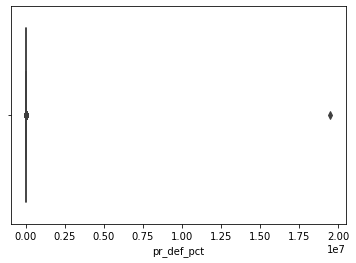

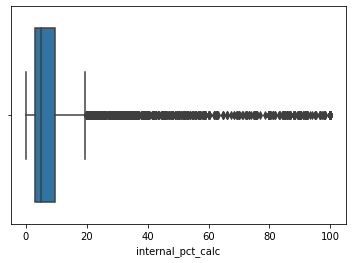

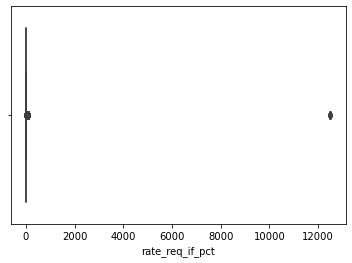

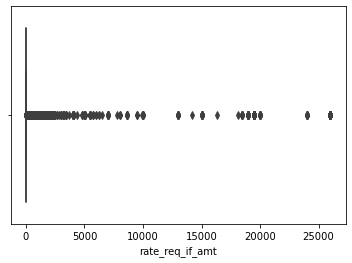

In [53]:
# investigating participant request records, I suspect that some cleaning needs to be done

columns = ['pr_def_pct', 'internal_pct_calc', 'rate_req_if_pct', 'rate_req_if_amt']
for col in columns:
    sns.boxplot(x=col, data=df)
    plt.show()

In [54]:
# I'm going to delete any PR rates > 100%
# These outliers should be found and addressed prior to the scrub 

df = df[df['pr_def_pct'] <= 100]

In [55]:
# I'm going to delete any records with contribution rate requests > 100%
# These outliers are internal input errors and should be corrected in our system prior to the scrub

df = df[df['rate_req_if_pct'] <= 100]

In [56]:
# I'm going to delete any records with contribution rate requests >= $19500 (the irs limit)
# These outliers are internal input errors and should be corrected in our system prior to the scrub

df = df[df['rate_req_if_amt'] < 19500]

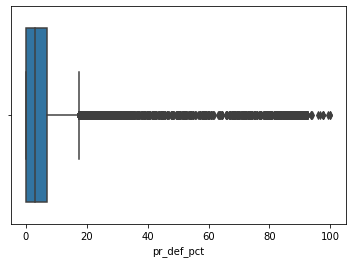

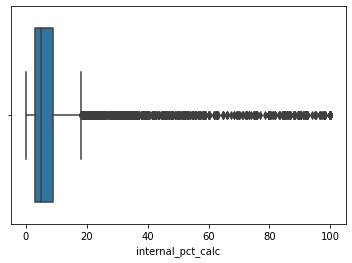

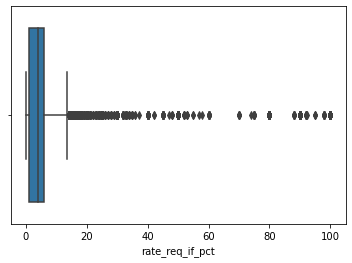

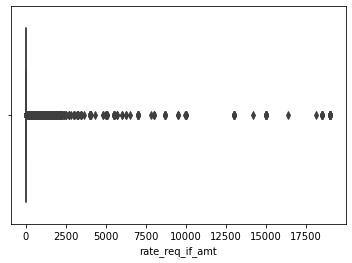

In [57]:
columns = ['pr_def_pct', 'internal_pct_calc', 'rate_req_if_pct', 'rate_req_if_amt']
for col in columns:
    sns.boxplot(x=col, data=df)
    plt.show()

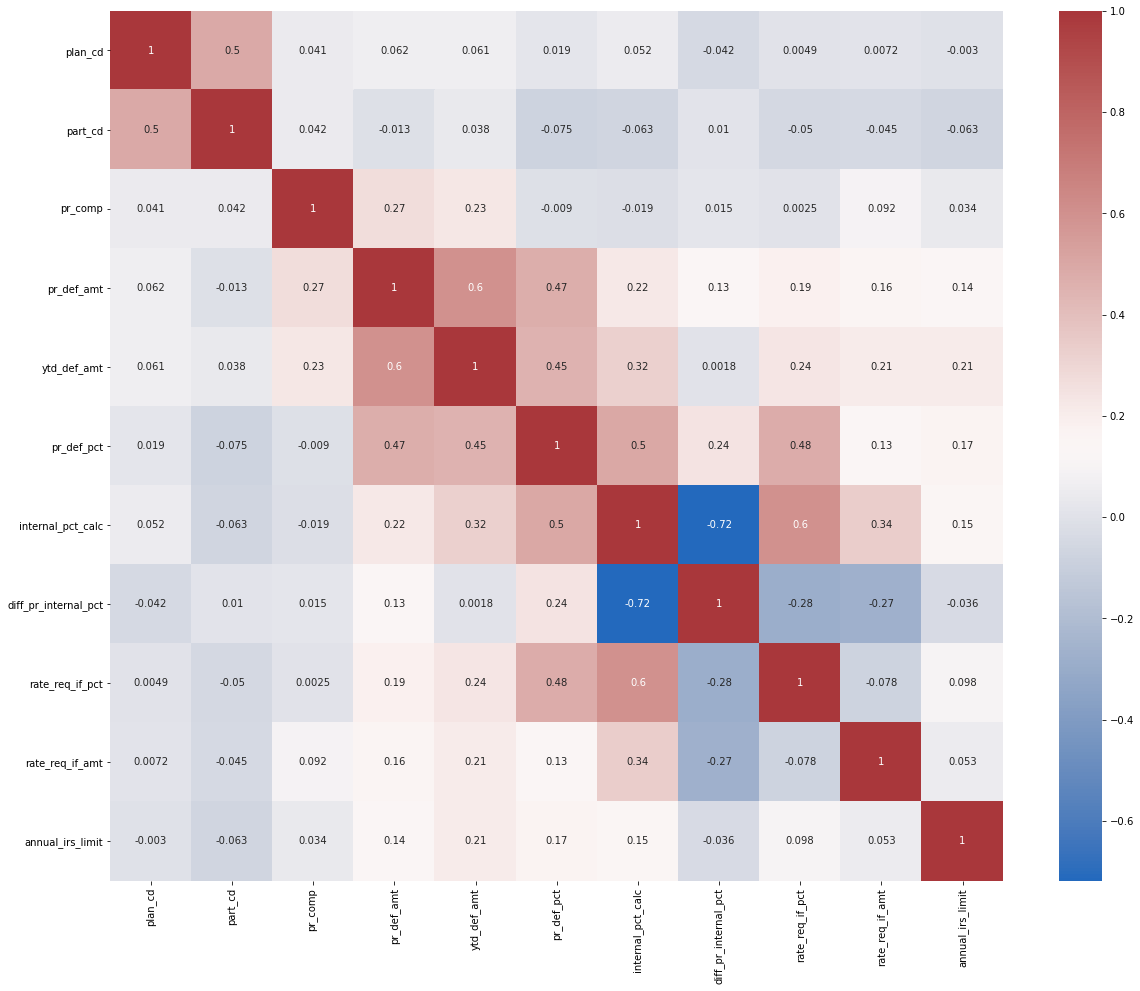

In [58]:
# heatmap

plt.subplots(figsize=(20,16))
sns.heatmap(df.corr(), annot=True, cmap='vlag')
plt.show()

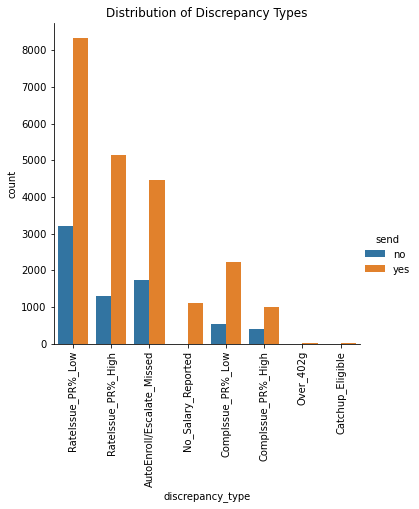

In [59]:
# discrepancy types

sns.catplot(x='discrepancy_type', hue='send', data=df, kind='count')
plt.xticks(rotation=90)
plt.title('Distribution of Discrepancy Types')
plt.show()

In [60]:
# Saving data

df = df.drop(columns=['internal_scrub_comments', 'report_date'])
df.to_csv('../data/interim/DVdata.csv')